In [1]:
import ast
import pathlib
from typing import Optional

import japanize_matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# FutureWarningのメッセージに従って
pd.set_option('future.no_silent_downcasting', True)

In [2]:
DATA_DIR = pathlib.Path('../data')

# 1. 準備
可視化に使用するデータと関数を準備します。  

## 1-1. データの読み込み

In [3]:
DATA_PATH = DATA_DIR / 'papers_llm_med.csv'

In [4]:
df = pd.read_csv(DATA_PATH)
df['categories'] = df.categories.apply(lambda cats: ast.literal_eval(cats))

print(f'{len(df):,}')
df.head(2)

191,185


,date,year_month,title,abstract,categories,url,related_to_medicine,related_to_llm
0,2022-01-01,2022-01,PatchTrack: Multiple Object Tracking Using Fra...,Object motion and object appearance are common...,[cs.CV],https://arxiv.org/abs/2201.00080,0,0
1,2022-01-01,2022-01,Automated Fake News Detection using cross-chec...,"Over the past decade, fake news and misinforma...","[cs.CL, cs.SI, physics.soc-ph]",https://arxiv.org/abs/2201.00083,0,0


## 1-2. データ整形／可視化用の関数の準備

In [5]:
COUNT_COL = 'count'
CATEGORY_COL = 'category'
CATEGORY_JP_COL = 'カテゴリ'
CATEGORIES_COL = 'categories'
YEAR_MONTH_COL = 'year_month'

START_YEAR_MONTH = '2022-01'
END_YEAR_MONTH = '2024-01'
YEAR_MONTHS = [ts.strftime('%Y-%m') for ts in pd.date_range(START_YEAR_MONTH, END_YEAR_MONTH, freq='ME')]

# https://arxiv.org/category_taxonomy の cs / stat カテゴリ一覧から以下を除外したもの
# 1. LLMが所属するべきカテゴリである cs.CL
# 2. カテゴリの定義が「AI/機械学習全般」「その他」となっている cs.AI / cs.LG / cs.OH / stat.ML / stat.OT
TARGET_CATEGORIES = ['cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL',
                     'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT',
                     'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OS', 'cs.PF', 'cs.PL',
                     'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'stat.AP', 'stat.CO', 'stat.ME', 'stat.TH']
CATEGORY_NAME2DETAIL = {
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.TH': 'Statistics Theory',
}


def count_by_year_month(df: pd.DataFrame) -> pd.DataFrame:
    """年月を軸に論文数をカウントする"""
    # 年月ごとに論文数をカウントする
    df_count = df.groupby(YEAR_MONTH_COL).size().to_frame().rename(columns={0: COUNT_COL})

    # 年月が網羅されていない場合があるので、0で補完する
    index = pd.Index(YEAR_MONTHS, name=YEAR_MONTH_COL)
    df_draft = pd.DataFrame(0, index=index, columns=[COUNT_COL])
    df_draft.update(df_count)

    return df_draft


def count_by_year_month_and_category(df: pd.DataFrame) -> pd.DataFrame:
    """年月とカテゴリを軸に論文数をカウントする"""
    # 年月とカテゴリのペアをすべて取得する
    rows = []
    for row in df.itertuples():
        rows.extend([
            {YEAR_MONTH_COL: getattr(row, YEAR_MONTH_COL), CATEGORY_COL: cat}
            for cat in getattr(row, CATEGORIES_COL) if cat in TARGET_CATEGORIES
        ])
    df_count = pd.DataFrame.from_dict(rows)

    # 上をもとに「年月 x カテゴリ」のデータフレームを作成する
    df_count_matrix = pd.crosstab(df_count[YEAR_MONTH_COL], df_count[CATEGORY_COL])

    # 年月やカテゴリが網羅されていない場合があるので、0で補完する
    index = pd.Index(YEAR_MONTHS, name=YEAR_MONTH_COL)
    columns = pd.Index(TARGET_CATEGORIES, name=CATEGORY_COL)
    df_draft = pd.DataFrame(0, index=index, columns=columns)
    df_draft.update(df_count_matrix)

    return df_draft


def lineplot(df: pd.DataFrame, topn: Optional[int] = None, categories: Optional[list[str]] = None, **kwargs) -> None:
    """折れ線グラフを描画する"""
    # count_by_year_month_and_category()で作成したデータフレームの場合
    if COUNT_COL not in df:
        df = df.sort_values(list(reversed(df.index)), axis=1, ascending=False)

        cols = []
        if topn is not None:
            cols.extend(df.columns[:topn].tolist())
        if categories is not None:
            cols.extend([cat for cat in categories if cat not in cols])
        if cols:
            df = df.loc[:, cols]

        df.rename(columns={name: f'{name} ({detail})' for name, detail in CATEGORY_NAME2DETAIL.items()}, inplace=True)
        df.rename_axis(CATEGORY_JP_COL, axis=1, inplace=True)

    df.plot(use_index=True, grid=True, xticks=range(len(df)), rot=90, **kwargs)
    plt.show()

## 1-3. データの整形

In [6]:
df_count = count_by_year_month(df)
df_llm_count = count_by_year_month(df[df.related_to_llm == 1])
df_med_count = count_by_year_month(df[df.related_to_medicine == 1])
df_llm_med_count = count_by_year_month(df[(df.related_to_llm == 1) & (df.related_to_medicine == 1)])

df_count.tail(2)

,count
year_month,
2023-11,9443
2023-12,8897


In [7]:
df_count_matrix = count_by_year_month_and_category(df)
df_llm_count_matrix = count_by_year_month_and_category(df[df.related_to_llm == 1])
df_med_count_matrix = count_by_year_month_and_category(df[df.related_to_medicine == 1])
df_llm_med_count_matrix = count_by_year_month_and_category(df[(df.related_to_llm == 1) & (df.related_to_medicine == 1)])

df_count_matrix.tail(2)

category,cs.AR,cs.CC,cs.CE,cs.CG,cs.CR,cs.CV,cs.CY,cs.DB,cs.DC,cs.DL,...,cs.RO,cs.SC,cs.SD,cs.SE,cs.SI,cs.SY,stat.AP,stat.CO,stat.ME,stat.TH
year_month,,,,,,,,,,,,,,,,,,,,,
2023-11,97,71,128,38,449,2359,266,82,251,33,...,555,16,144,217,170,498,191,56,316,179
2023-12,67,78,85,45,489,2456,252,100,211,31,...,521,19,217,209,156,440,170,57,311,137


# 2. 可視化
上で準備したデータをもとに可視化を行っていきます。  

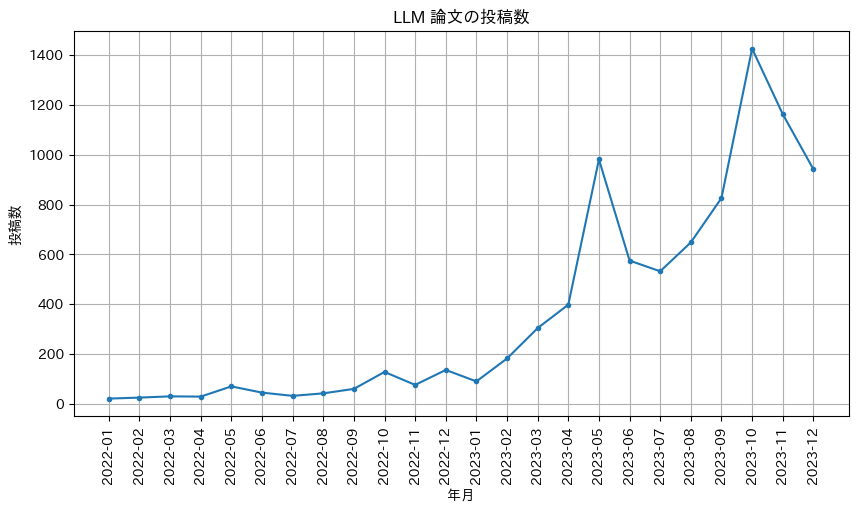

In [8]:
lineplot(df_llm_count, figsize=(10, 5), marker='.',
         title='LLM 論文の投稿数', legend=False, xlabel='年月', ylabel='投稿数')

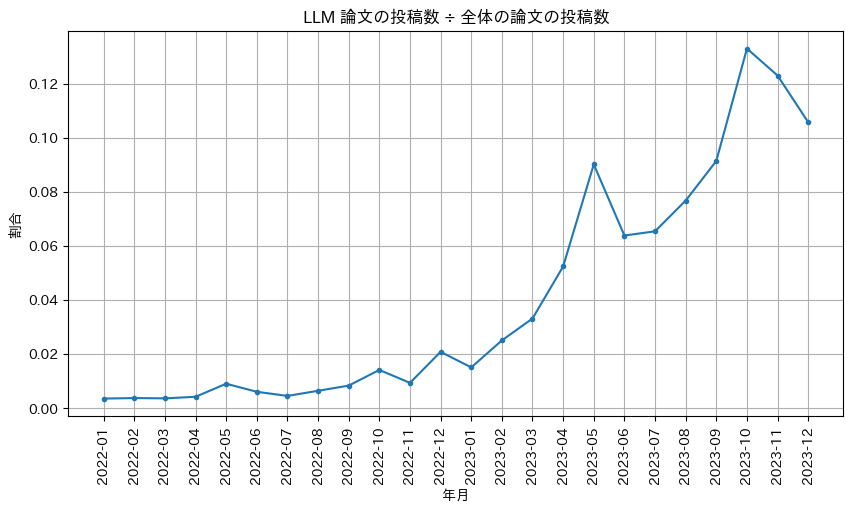

In [9]:
lineplot(df_llm_count / df_count, figsize=(10, 5), marker='.',
         title='LLM 論文の投稿数 ÷ 全体の論文の投稿数', legend=False, xlabel='年月', ylabel='割合')

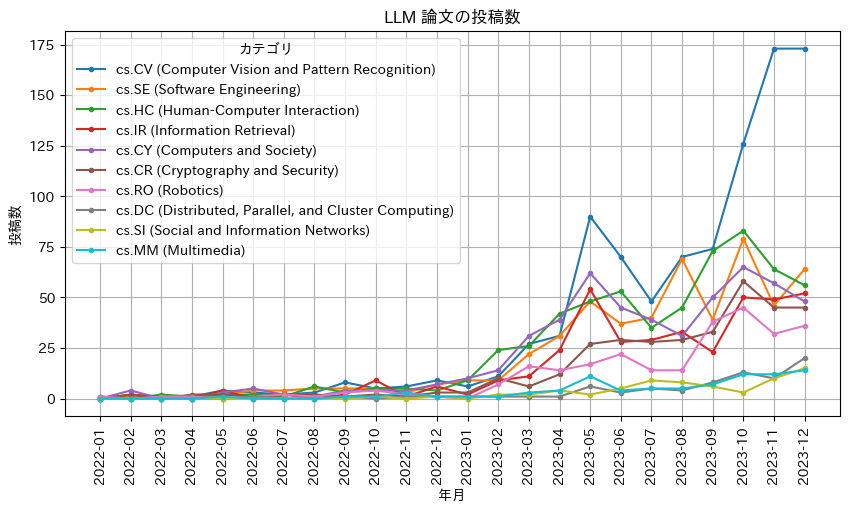

In [10]:
lineplot(df_llm_count_matrix, figsize=(10, 5), marker='.', topn=10,
         title='LLM 論文の投稿数', legend=True, xlabel='年月', ylabel='投稿数')

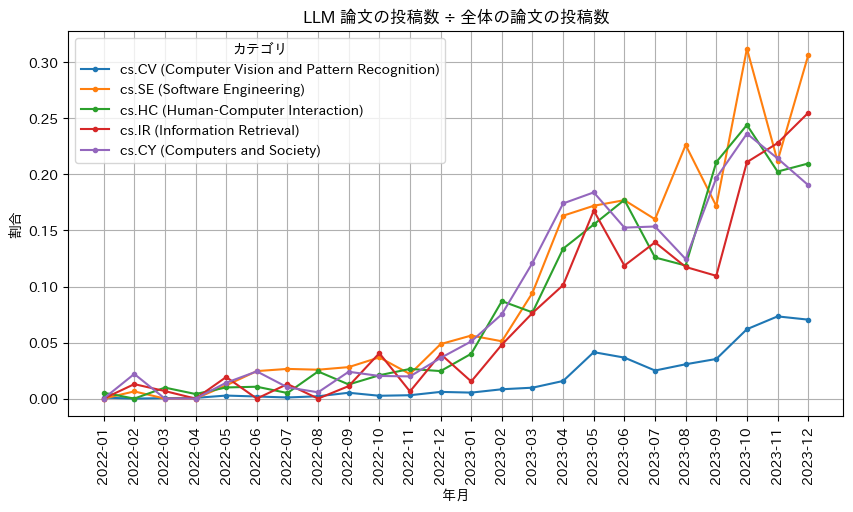

In [11]:
lineplot(df_llm_count_matrix / df_count_matrix, figsize=(10, 5), marker='.',
         title='LLM 論文の投稿数 ÷ 全体の論文の投稿数', legend=True, xlabel='年月', ylabel='割合',
         categories=['cs.CV', 'cs.SE', 'cs.HC', 'cs.IR', 'cs.CY'])

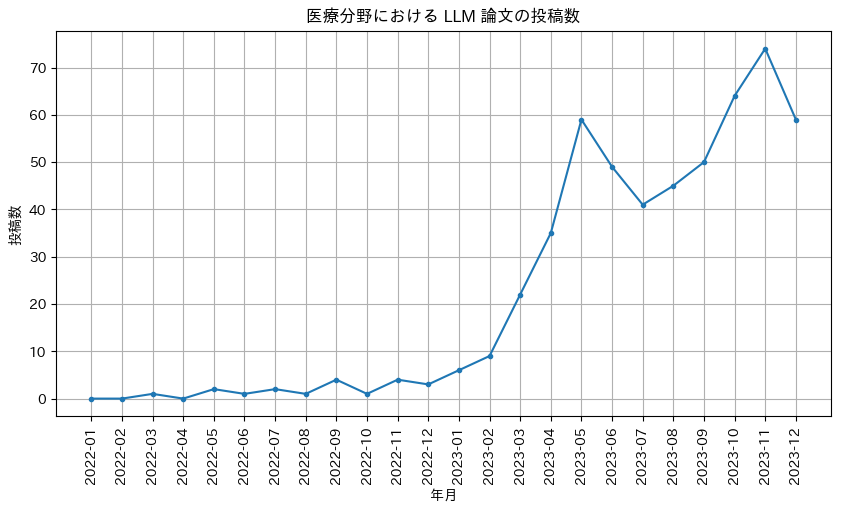

In [12]:
lineplot(df_llm_med_count, figsize=(10, 5), marker='.',
         title='医療分野における LLM 論文の投稿数', legend=False, xlabel='年月', ylabel='投稿数')

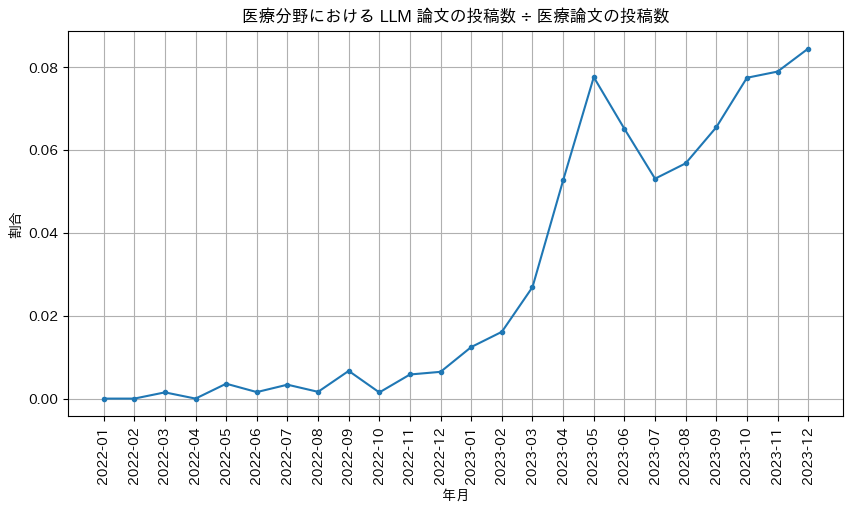

In [13]:
lineplot(df_llm_med_count / df_med_count, figsize=(10, 5), marker='.',
         title='医療分野における LLM 論文の投稿数 ÷ 医療論文の投稿数', legend=False, xlabel='年月', ylabel='割合')

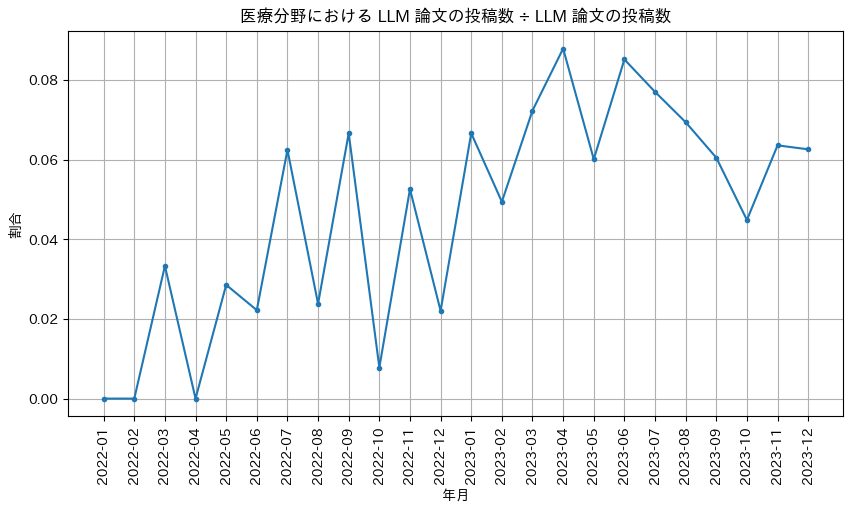

In [14]:
lineplot(df_llm_med_count / df_llm_count, figsize=(10, 5), marker='.',
         title='医療分野における LLM 論文の投稿数 ÷ LLM 論文の投稿数', legend=False, xlabel='年月', ylabel='割合')

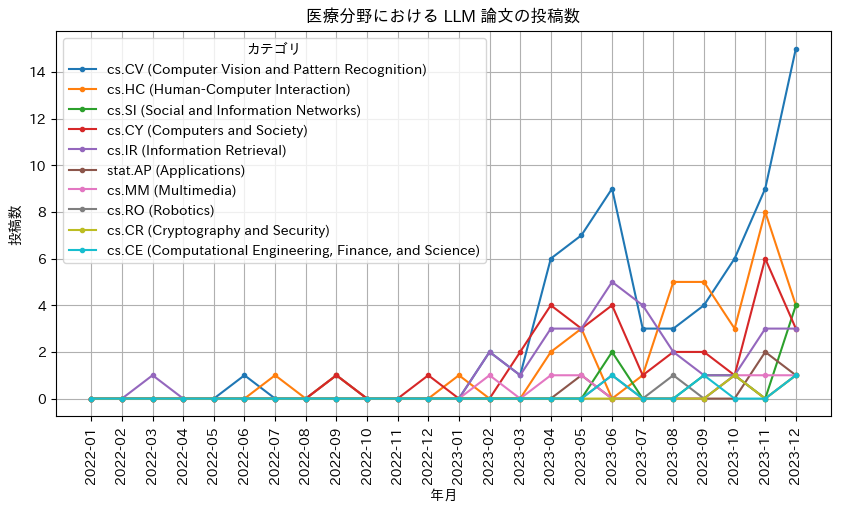

In [15]:
lineplot(df_llm_med_count_matrix, figsize=(10, 5), topn=10, marker='.',
         title='医療分野における LLM 論文の投稿数', legend=True, xlabel='年月', ylabel='投稿数')